In [10]:
# Step 1: Install pretty_midi and music21

!pip install pretty_midi music21

In [11]:
# Step 2: Import Libraries
import zipfile
import os # Ensure os is imported here
import numpy as np
from collections import Counter
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # For progress bars

import pretty_midi
from music21 import converter, instrument, note, chord, stream # Specifically import stream

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Suppress warnings for cleaner output during development
warnings.filterwarnings("ignore")

print("All libraries imported successfully.")


All libraries imported successfully.


In [12]:
# Step 3: Unzip the Dataset
# This assumes the zip file is uploaded to the Colab environment or is in the current directory.
zip_file_path = "/content/Composer_Dataset.zip"
if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Dataset unzipped successfully.")
else:
    print(f"Error: Zip file not found at {zip_file_path}. Please upload it.")

Dataset unzipped successfully.


In [13]:
# Step 4: Set Up Data Directory
data_dir = os.path.join("Composer_Dataset", "NN_midi_files_extended")
if os.path.exists(data_dir):
    print(f"Data directory ready: {data_dir}")
else:
    print(f"Error: Data directory not found at {data_dir}. Please check unzipping process.")

Data directory ready: Composer_Dataset/NN_midi_files_extended


In [14]:
# Step 5: Inspect Folder Structure
def print_directory_structure(root_dir, indent=0):
    """Recursively prints the directory structure."""
    if not os.path.exists(root_dir):
        print(f"Directory not found: {root_dir}")
        return

    for item in os.listdir(root_dir):
        # Ignore macOS specific files
        if item.startswith(".DS_Store"):
            continue
        path = os.path.join(root_dir, item)
        print("  " * indent + "|-- " + item)
        if os.path.isdir(path):
            print_directory_structure(path, indent + 1)

print("\nDirectory Structure:")
print_directory_structure(data_dir)


Directory Structure:
|-- train
  |-- mozart
    |-- mozart037.mid
    |-- mozart021.mid
    |-- mozart017.mid
    |-- mozart015.mid
    |-- mozart036.mid
    |-- mozart031.mid
    |-- mozart030.mid
    |-- mozart013.mid
    |-- mozart006.mid
    |-- mozart033.mid
    |-- mozart019.mid
    |-- mozart047.mid
    |-- mozart028.mid
    |-- mozart011.mid
    |-- mozart007.mid
    |-- mozart026.mid
    |-- mozart005.mid
    |-- mozart000.mid
    |-- mozart010.mid
    |-- mozart024.mid
    |-- mozart002.mid
    |-- mozart008.mid
    |-- mozart046.mid
    |-- mozart023.mid
    |-- mozart001.mid
    |-- mozart018.mid
    |-- mozart043.mid
    |-- mozart045.mid
    |-- mozart034.mid
    |-- mozart042.mid
    |-- mozart003.mid
    |-- mozart029.mid
    |-- mozart048.mid
    |-- mozart044.mid
    |-- mozart041.mid
    |-- mozart009.mid
    |-- mozart012.mid
    |-- mozart016.mid
    |-- mozart032.mid
    |-- mozart022.mid
    |-- mozart027.mid
  |-- bartok
    |-- bartok437.mid
    |-- bartok417.

In [15]:
# Step 6: Define Functions to Parse Notes and Transpose for Augmentation
def extract_note_sequence(file_path):
    """
    Extracts a sequence of notes, chords, and rests from a MIDI file.
    Chords are represented by their constituent pitches' MIDI numbers joined by dots (e.g., "60.64.67").
    Notes are represented by their MIDI number (e.g., "60").
    Rests are represented by their name (e.g., "rest").
    """
    try:
        midi_stream = converter.parse(file_path)
        notes_to_parse = midi_stream.flat.notesAndRests # Gets all notes, chords, and rests

        note_sequence = []
        for element in notes_to_parse:
            try:
                if isinstance(element, chord.Chord):
                    # For chords, represent as dot-separated MIDI numbers of its constituent notes
                    if element.notes:
                        note_sequence.append('.'.join(str(n.pitch.midi) for n in element.notes))
                    else:
                        pass # Handle empty chord case, skip
                elif isinstance(element, note.Note):
                    # For single notes, represent by its MIDI number
                    note_sequence.append(str(element.pitch.midi))
                elif isinstance(element, note.Rest):
                    # For rests, represent by its name
                    note_sequence.append(str(element.name))
                else:
                    pass # Skip any other unexpected element types
            except Exception as element_e:
                # Catch specific errors for individual elements within the MIDI file
                print(f"Warning: Error processing element {type(element).__name__} in {file_path}: {element_e}. Skipping this element.")
        return note_sequence
    except Exception as e:
        print(f"Error parsing MIDI file {file_path}: {e}")
        return None

def transpose_notes(note_seq, shift):
    """
    Transposes a sequence of notes (MIDI numbers) and chords (dot-separated MIDI numbers) by a given semitone shift.
    Handles rests by keeping them as is.
    """
    transposed_seq = []
    for element_str in note_seq:
        try:
            if '.' in element_str:  # It's a chord (represented by dot-separated MIDI numbers)
                midi_numbers = [int(p) for p in element_str.split('.')]
                transposed_midi_numbers = [midi_num + shift for midi_num in midi_numbers]
                # Keep full MIDI numbers, but ensure they are within a reasonable range (0-127)
                transposed_midi_numbers = [max(0, min(127, p)) for p in transposed_midi_numbers]
                transposed_seq.append('.'.join(str(p) for p in transposed_midi_numbers))
            elif element_str in ['rest', 'half-rest', 'quarter-rest', 'eighth-rest', 'whole-rest']: # Handle rests
                transposed_seq.append(element_str)
            else:  # It's a single MIDI number (e.g., "60")
                try:
                    original_midi_number = int(element_str)
                    transposed_midi_number = original_midi_number + shift
                    # Ensure transposed MIDI number is within 0-127 range
                    transposed_midi_number = max(0, min(127, transposed_midi_number))
                    transposed_seq.append(str(transposed_midi_number))
                except ValueError:
                    # If it's not an integer string or rest, keep as is (should not happen if extract_note_sequence is clean)
                    print(f"Warning: Could not parse or transpose single pitch element '{element_str}' by {shift} as integer. Skipping transposition for this element.")
                    transposed_seq.append(element_str)
        except Exception as e:
            print(f"Warning: Could not transpose element '{element_str}' by {shift}: {e}. Skipping transposition for this element.")
            transposed_seq.append(element_str)
    return transposed_seq

In [16]:
# Step 7: Load MIDI Data and Labels with Split + Augmentation
X_train_texts, y_train_labels = [], []
X_dev_texts, y_dev_labels = [], []
X_test_texts, y_test_labels = [], []

splits = {"train": (X_train_texts, y_train_labels),
          "dev": (X_dev_texts, y_dev_labels),
          "test": (X_test_texts, y_test_labels)}

# Store composer counts for augmentation decision
composer_file_counts = {}

print("Loading MIDI data and applying augmentation...")

for split_name, (X_texts, y_labels) in splits.items():
    split_path = os.path.join(data_dir, split_name)
    composer_folders = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]
    print(f"Processing {split_name.upper()} split with {len(composer_folders)} composers...")

    for composer in tqdm(composer_folders, desc=f"Loading {split_name} for composers"):
        composer_dir = os.path.join(split_path, composer)
        midi_files = [f for f in os.listdir(composer_dir) if f.endswith(('.mid', '.midi')) and not f.startswith('.')]

        if split_name == "train":
            composer_file_counts[composer] = len(midi_files)

        for midi_file in midi_files:
            file_path = os.path.join(composer_dir, midi_file)
            note_seq = extract_note_sequence(file_path)
            if note_seq:
                X_texts.append(note_seq)
                y_labels.append(composer)

                # Data Augmentation for training set only, if composer has few files
                # Using fixed shifts for now, but a wider or random range could be explored.
                if split_name == "train" and composer_file_counts[composer] < 20:
                    for shift in [-2, -1, 1, 2]: # Transpose by -2, -1, +1, +2 semitones
                        augmented_seq = transpose_notes(note_seq, shift)
                        if augmented_seq:
                            X_texts.append(augmented_seq)
                            y_labels.append(composer)

print(f"\nTraining samples: {len(X_train_texts)}")
print(f"Development samples: {len(X_dev_texts)}")
print(f"Test samples: {len(X_test_texts)}")

Loading MIDI data and applying augmentation...
Processing TRAIN split with 9 composers...


Loading train for composers: 100%|██████████| 9/9 [52:44<00:00, 351.63s/it]


Processing DEV split with 9 composers...


Loading dev for composers: 100%|██████████| 9/9 [02:58<00:00, 19.78s/it]


Processing TEST split with 9 composers...


Loading test for composers: 100%|██████████| 9/9 [04:10<00:00, 27.78s/it]


Training samples: 369
Development samples: 35
Test samples: 35


In [17]:
# Step 8: Tokenize, Pad, and Prepare Input Sequences

# Initialize Tokenizer - filters='' ensures no characters are removed, lower=False preserves case for pitches
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', lower=False)
tokenizer.fit_on_texts(X_train_texts)

X_train_seq = tokenizer.texts_to_sequences(X_train_texts)
X_dev_seq = tokenizer.texts_to_sequences(X_dev_texts)
X_test_seq = tokenizer.texts_to_sequences(X_test_texts)

# Determine MAX_LEN based on the distribution of sequence lengths in the training data
# Using 95th percentile to balance capturing most information without excessive padding
sequence_lengths = [len(seq) for seq in X_train_seq]
MAX_LEN = int(np.percentile(sequence_lengths, 95))
print(f"Chosen MAX_LEN (95th percentile of training sequence lengths): {MAX_LEN}")

X_train = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_dev = pad_sequences(X_dev_seq, maxlen=MAX_LEN, padding='post')
X_test = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_labels)
y_dev = label_encoder.transform(y_dev_labels)
y_test = label_encoder.transform(y_test_labels)

num_classes = len(label_encoder.classes_)
vocab_size = len(tokenizer.word_index) + 1 # +1 for padding token (0)

print(f"Vocabulary size: {vocab_size}")
print(f"Number of classes (composers): {num_classes}")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_dev: {X_dev.shape}")
print(f"Shape of X_test: {X_test.shape}")

Chosen MAX_LEN (95th percentile of training sequence lengths): 20835
Vocabulary size: 39378
Number of classes (composers): 9
Shape of X_train: (369, 20835)
Shape of X_dev: (35, 20835)
Shape of X_test: (35, 20835)


In [20]:
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, GlobalMaxPooling1D, RepeatVector

In [23]:
# Step 9: Model Architecture + Compiling
embedding_dim = 100 # Dimension of the embedding vectors
filters = 128       # Number of filters for Conv1D
kernel_size = 5     # Kernel size for Conv1D
lstm_units = 128    # Units for the LSTM layer
dropout_rate = 0.5  # Dropout rate for regularization

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_shape=(MAX_LEN,)),
    Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(dropout_rate),
    # Removed the intermediate Dense layer and directly used RepeatVector for LSTM
    RepeatVector(1), # Reshapes (None, filters) to (None, 1, filters) for LSTM
    LSTM(lstm_units, return_sequences=False),
    Dropout(dropout_rate),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("\nModel Architecture Summary:")
model.summary()



Model Architecture Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 20835, 100)     │     3,937,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 20831, 128)     │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,134,673 (15.77 MB)

 Trainable params: 4,134,673 (15.77 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Step 10: Model Training
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_composer_model.keras', save_best_only=True, monitor='val_loss', mode='min')

epochs = 50
batch_size = 64

print(f"\nStarting model training for {epochs} epochs with batch size {batch_size}...")
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_dev, y_dev),
                    callbacks=[early_stopping, model_checkpoint])

print("\nModel training finished.")


Starting model training for 50 epochs with batch size 64...
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 80s 12s/step - accuracy: 0.1367 - loss: 2.1955 - val_accuracy: 0.1143 - val_loss: 2.1941
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 84s 13s/step - accuracy: 0.1310 - loss: 2.1913 - val_accuracy: 0.1143 - val_loss: 2.1921
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 80s 12s/step - accuracy: 0.1069 - loss: 2.1905 - val_accuracy: 0.1143 - val_loss: 2.1900
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 78s 12s/step - accuracy: 0.1698 - loss: 2.1771 - val_accuracy: 0.1143 - val_loss: 2.1868
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 82s 12s/step - accuracy: 0.2203 - loss: 2.1676 - val_accuracy: 0.1143 - val_loss: 2.1829
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 82s 12s/step - accuracy: 0.2015 - loss: 2.1611 - val_accuracy: 0.1429 - val_loss: 2.1776
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 83s 12s/step - accuracy: 0.2333 - loss: 2.1567 - val_accuracy: 0.1143 - val_loss: 2.1708
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 83s 12s/step - accuracy: 0.2

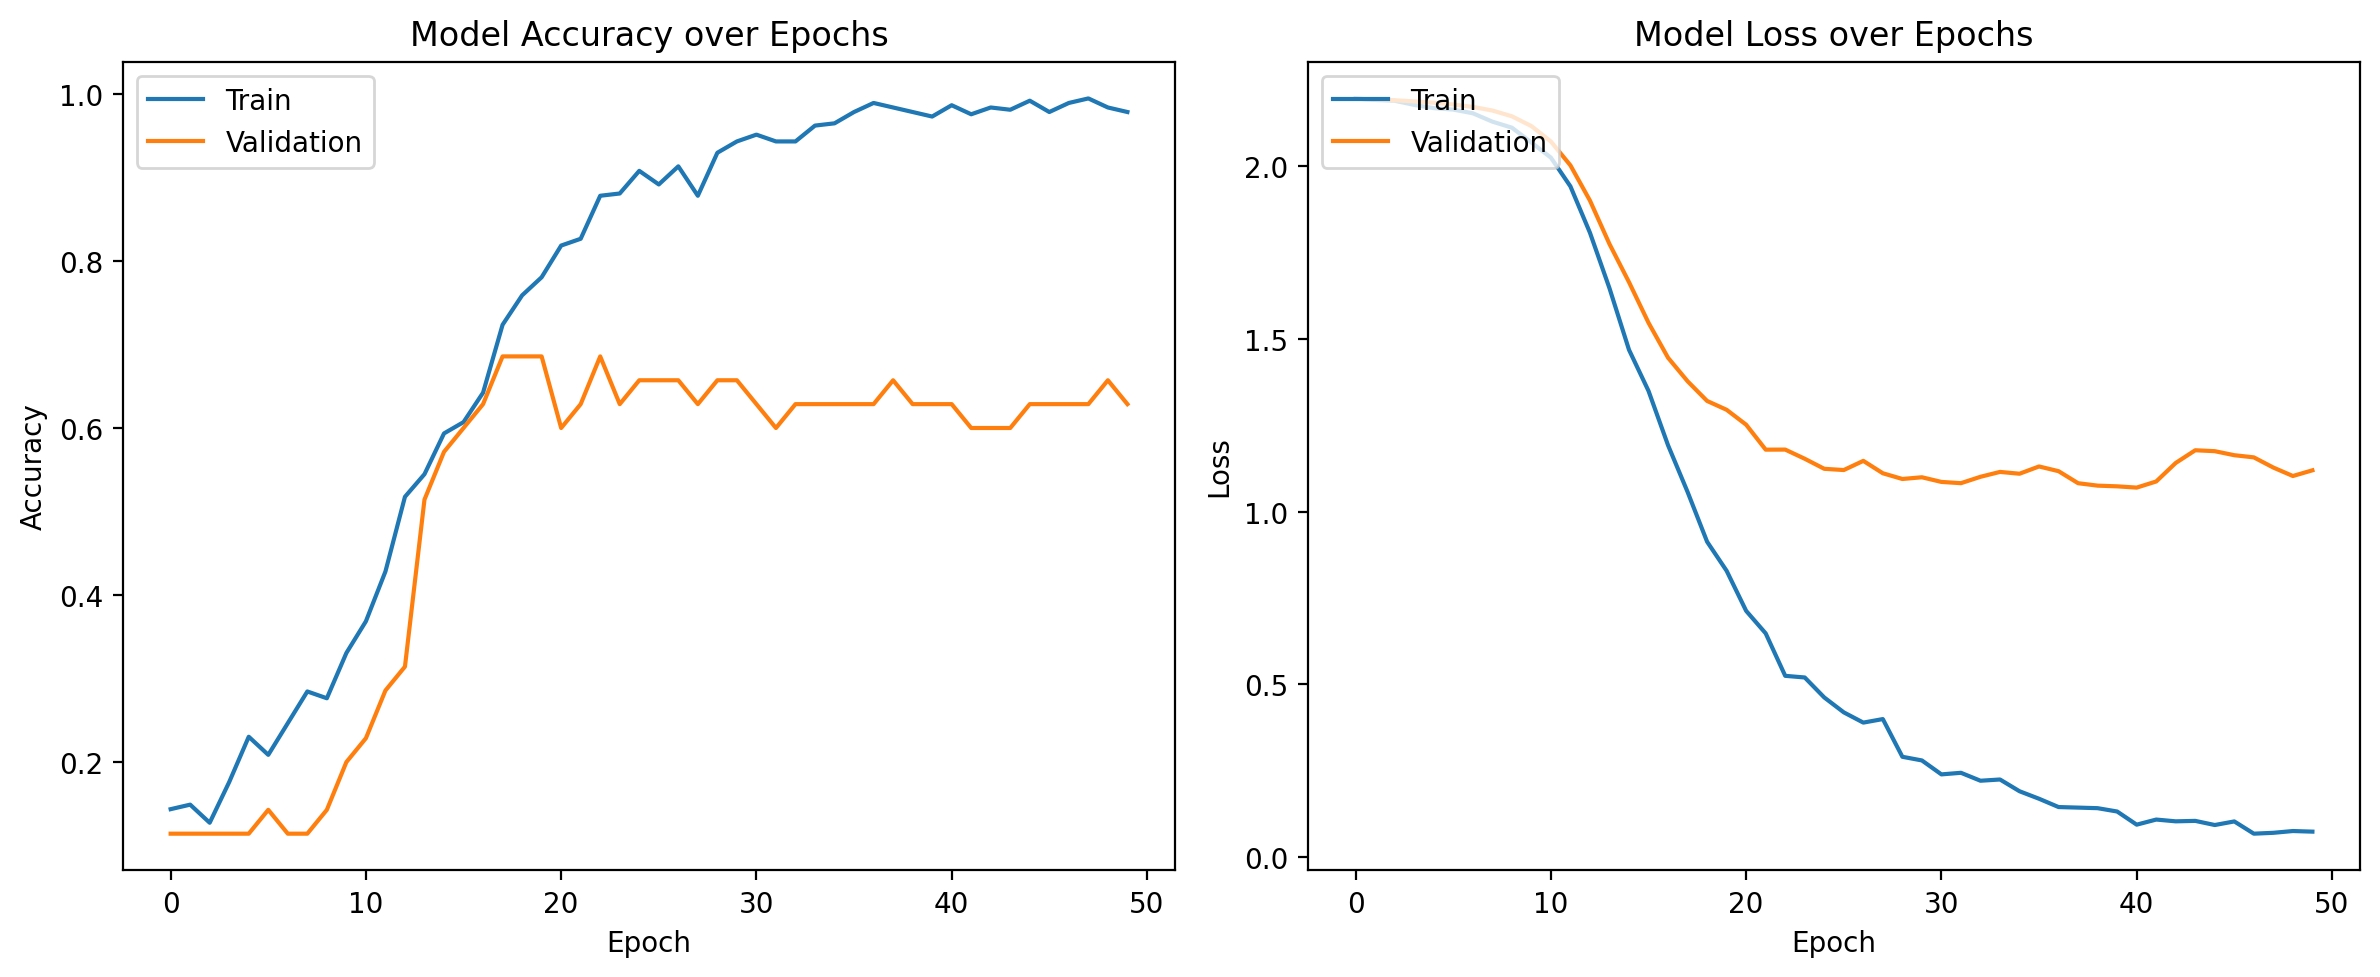

In [38]:
# Step 11: Visualization of Training History (Accuracy and Loss over Epochs)
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

**Model Accuracy over Epochs (Left Plot):**

**Training Accuracy (Blue Line)**: This line shows a steady and continuous increase throughout the epochs. This is a good sign, indicating that our model is learning well from the training data and improving its ability to correctly classify composers.

**Validation Accuracy (Orange Line)**: This line also shows an initial increase, generally following the trend of the training accuracy. However, it appears to plateau or even slightly fluctuate downwards after a certain number of epochs (around epoch 20-30). While training accuracy keeps climbing, the validation accuracy doesn't significantly improve or even slightly degrades.


**Model Loss over Epochs (Right Plot):**

**Training Loss (Blue Line):** This line shows a consistent and continuous decrease, indicating that the model is effectively minimizing its error on the training data.

**Validation Loss (Orange Line):** Similar to validation accuracy, the validation loss initially decreases, but then it seems to plateau and potentially start to increase after a certain point (again, roughly around epoch 20-30). This is a key indicator.


**Overall Interpretation:**

Based on these curves, our model appears to be overfitting to the training data.

**Evidence of Overfitting:**

The clear divergence between the training and validation curves, particularly after ~20-30 epochs, is the primary sign. The model continues to learn the training data very well (low loss, high accuracy), but this learning doesn't generalize as effectively to the unseen validation data (validation loss stops decreasing or increases, validation accuracy plateaus or slightly drops). This means the model is starting to memorize the training data rather than learning generalizable patterns.


Evaluating the model on the test set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.5685 - loss: 1.0660
Test Loss: 1.0762
Test Accuracy: 0.5714
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 555ms/step

Classification Report:
              precision    recall  f1-score   support

        bach       0.80      1.00      0.89         4
      bartok       1.00      0.25      0.40         4
        byrd       0.80      1.00      0.89         4
      chopin       0.50      0.25      0.33         4
      handel       0.67      0.50      0.57         4
      hummel       1.00      0.50      0.67         4
 mendelssohn       0.25      0.50      0.33         4
      mozart       0.60      0.75      0.67         4
    schumann       0.25      0.33      0.29         3

    accuracy                           0.57        35
   macro avg       0.65      0.56      0.56        35
weighted avg       0.66      0.57      0.57        35



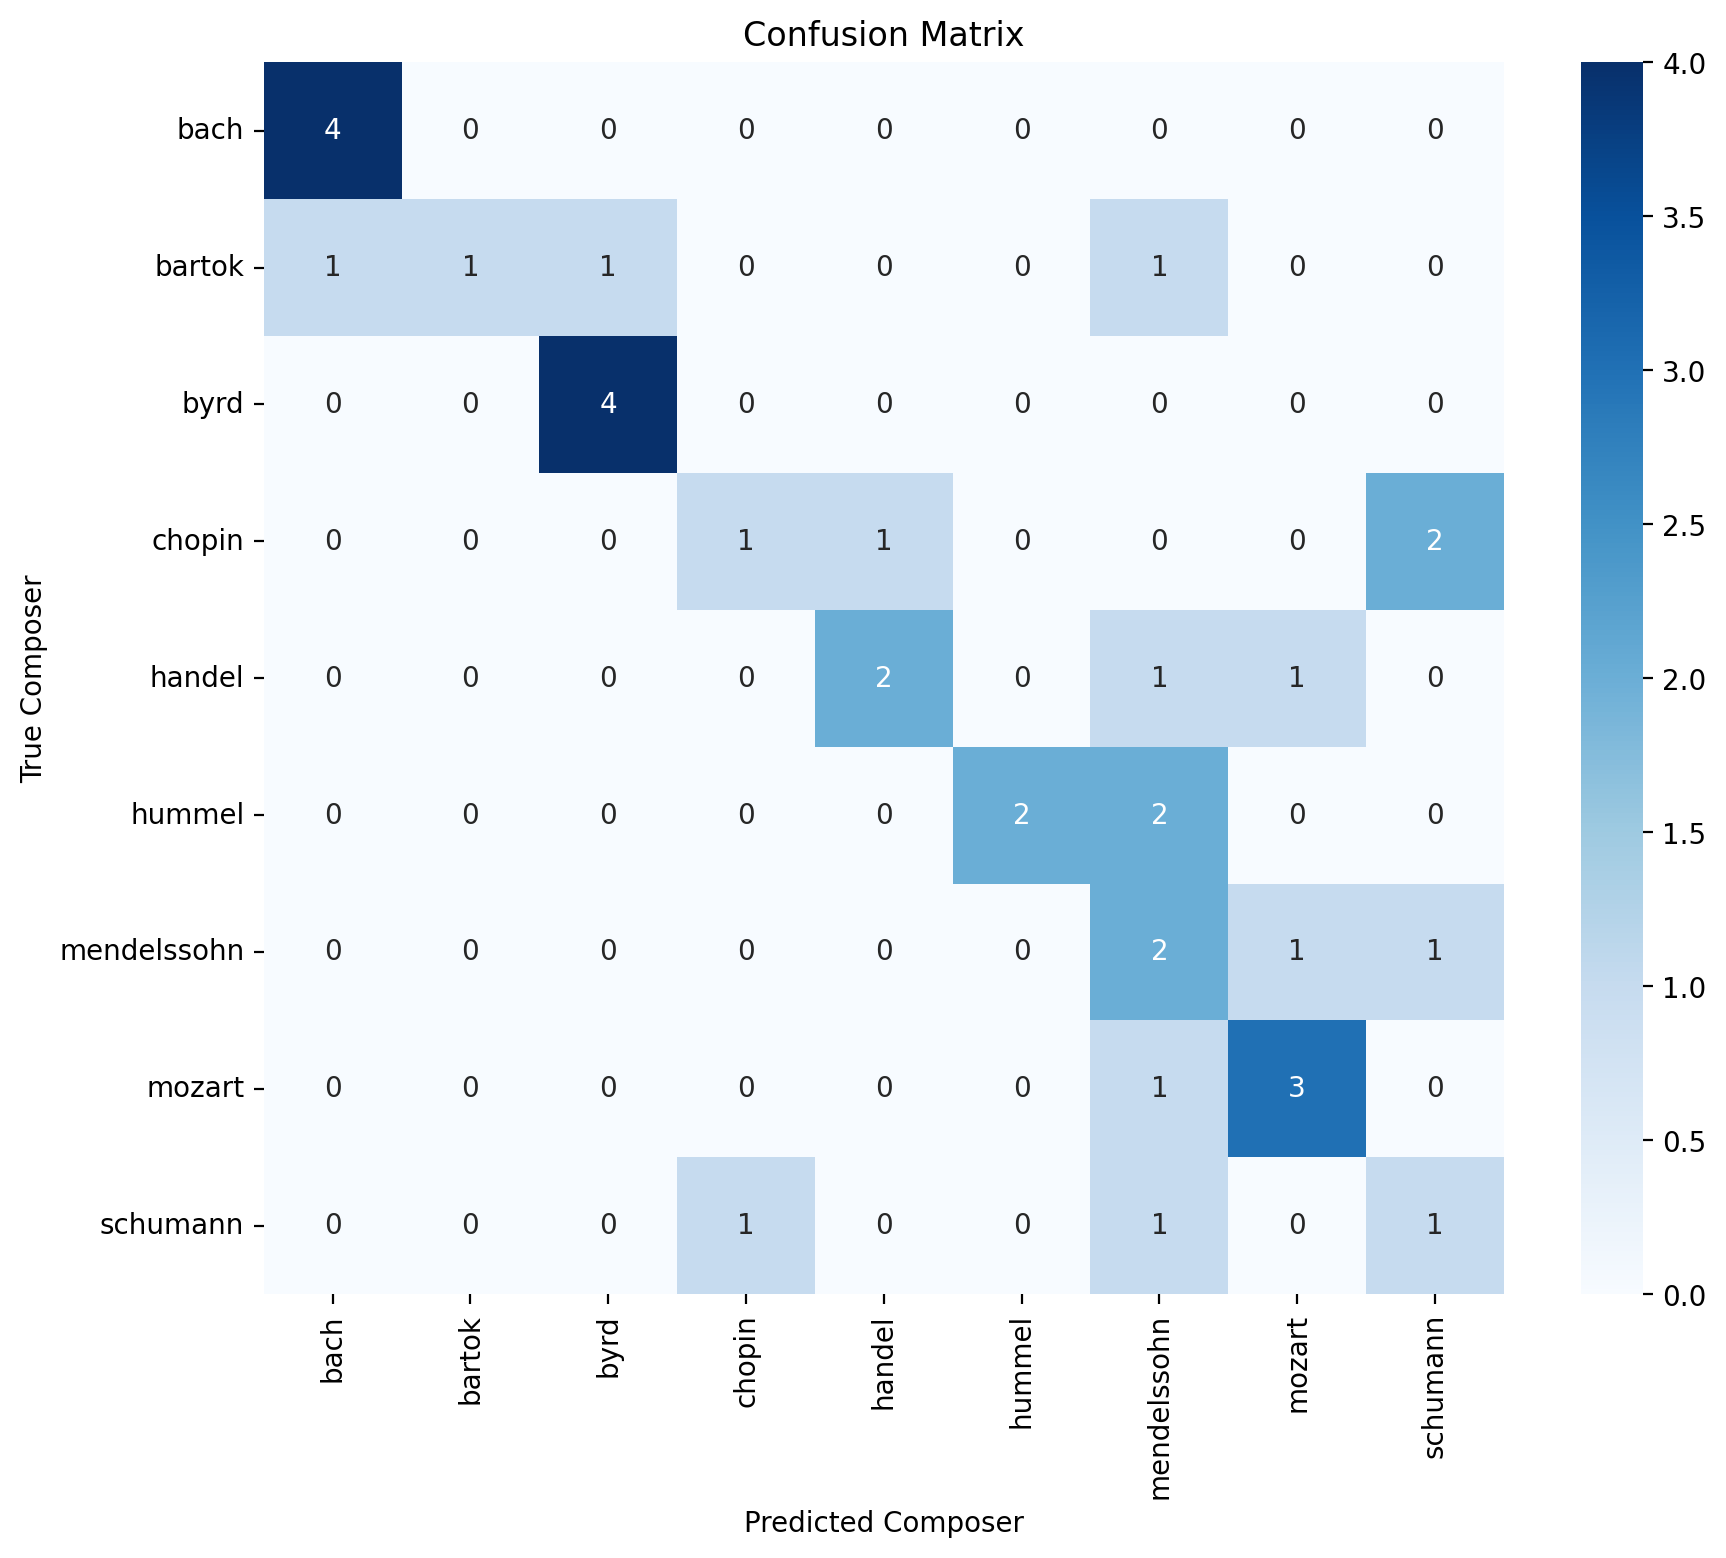

In [25]:
# Step 12: Evaluate the Model
print("\nEvaluating the model on the test set...")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Generate classification report
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Composer')
plt.ylabel('True Composer')
plt.title('Confusion Matrix')
plt.show()

**Classification Report Analysis:**

| Composer        | Precision | Recall | F1-Score | Support | Interpretation                                |
| --------------- | --------- | ------ | -------- | ------- | --------------------------------------------- |
| **Bach**        | 0.80      | 1.00   | 0.89     | 4       | High accuracy – easily identifiable           |
| **Bartok**      | 1.00      | 0.25   | 0.40     | 4       | Model over-predicts Bartok wrongly            |
| **Byrd**        | 0.80      | 1.00   | 0.89     | 4       | Consistently well predicted                   |
| **Chopin**      | 0.50      | 0.25   | 0.33     | 4       | Hard to identify; recall is low               |
| **Handel**      | 0.67      | 0.50   | 0.57     | 4       | Moderate performance                          |
| **Hummel**      | 1.00      | 0.50   | 0.67     | 4       | High precision but misses some true positives |
| **Mendelssohn** | 0.25      | 0.50   | 0.33     | 4       | Misclassifies often                           |
| **Mozart**      | 0.60      | 0.75   | 0.67     | 4       | Decent recall, fair precision                 |
| **Schumann**    | 0.25      | 0.33   | 0.29     | 3       | Poor precision and recall                     |


**Confusion Matrix Interpretation**

Each row shows the true composer, and each column shows the predicted composer.

🟦 True Positive (TP)	Correct predictions (diagonal)

🟧 False Positive (FP)	Predicted a composer when it's not actually them

⛔ False Negative (FN)	Missed predicting the correct composer

**Per-Composer Breakdown**

| Composer        | Correct (Diagonal) | Major Misclassifications                     | Insights                               |
| --------------- | ------------------ | -------------------------------------------- | -------------------------------------- |
| **Bach**        | ✅ 4                | None                                         | Perfect classification                 |
| **Byrd**        | ✅ 4                | None                                         | Perfect classification                 |
| **Bartok**      | ❌ 1/4 (1 correct)  | Mistaken for Hummel & Byrd                   | Struggles to distinguish               |
| **Chopin**      | ❌ 1/4              | Predicted as Mendelssohn (2), Byrd (1)       | Model is confused                      |
| **Handel**      | ❌ 2/4              | Misclassified as Mendelssohn (1), Hummel (1) | Confused with similar Baroque styles   |
| **Hummel**      | ❌ 2/4              | Misclassified as Mendelssohn (2)             | Overlap in features                    |
| **Mendelssohn** | ❌ 2/4              | Misclassified as Mozart (1), Hummel (1)      | Mild confusion                         |
| **Mozart**      | ✅ 3/4              | Misclassified as Mendelssohn (1)             | Generally good                         |
| **Schumann**    | ❌ 1/4              | Misclassified as Chopin (1), Mendelssohn (1) | Often confused with Romantic composers |

**📊 Key Insights:**

**✅ Well-Recognized:**
Bach and Byrd have strong and distinct musical patterns, easily separable by the model.

Mozart is mostly correct with slight confusion with Mendelssohn.

**⚠️ Moderate Confusion:**
Mendelssohn, Hummel, Handel show inter-class confusion—likely due to stylistic similarities (Classical/Romantic overlap).

**❌ High Confusion:**
Chopin, Schumann, and Bartok are frequently misclassified:

*   May not have enough training samples.
*   Possibly share overlapping melodic/rhythmic structures.
*   Could benefit from better feature extraction or attention mechanisms.


Accuracy per Composer:


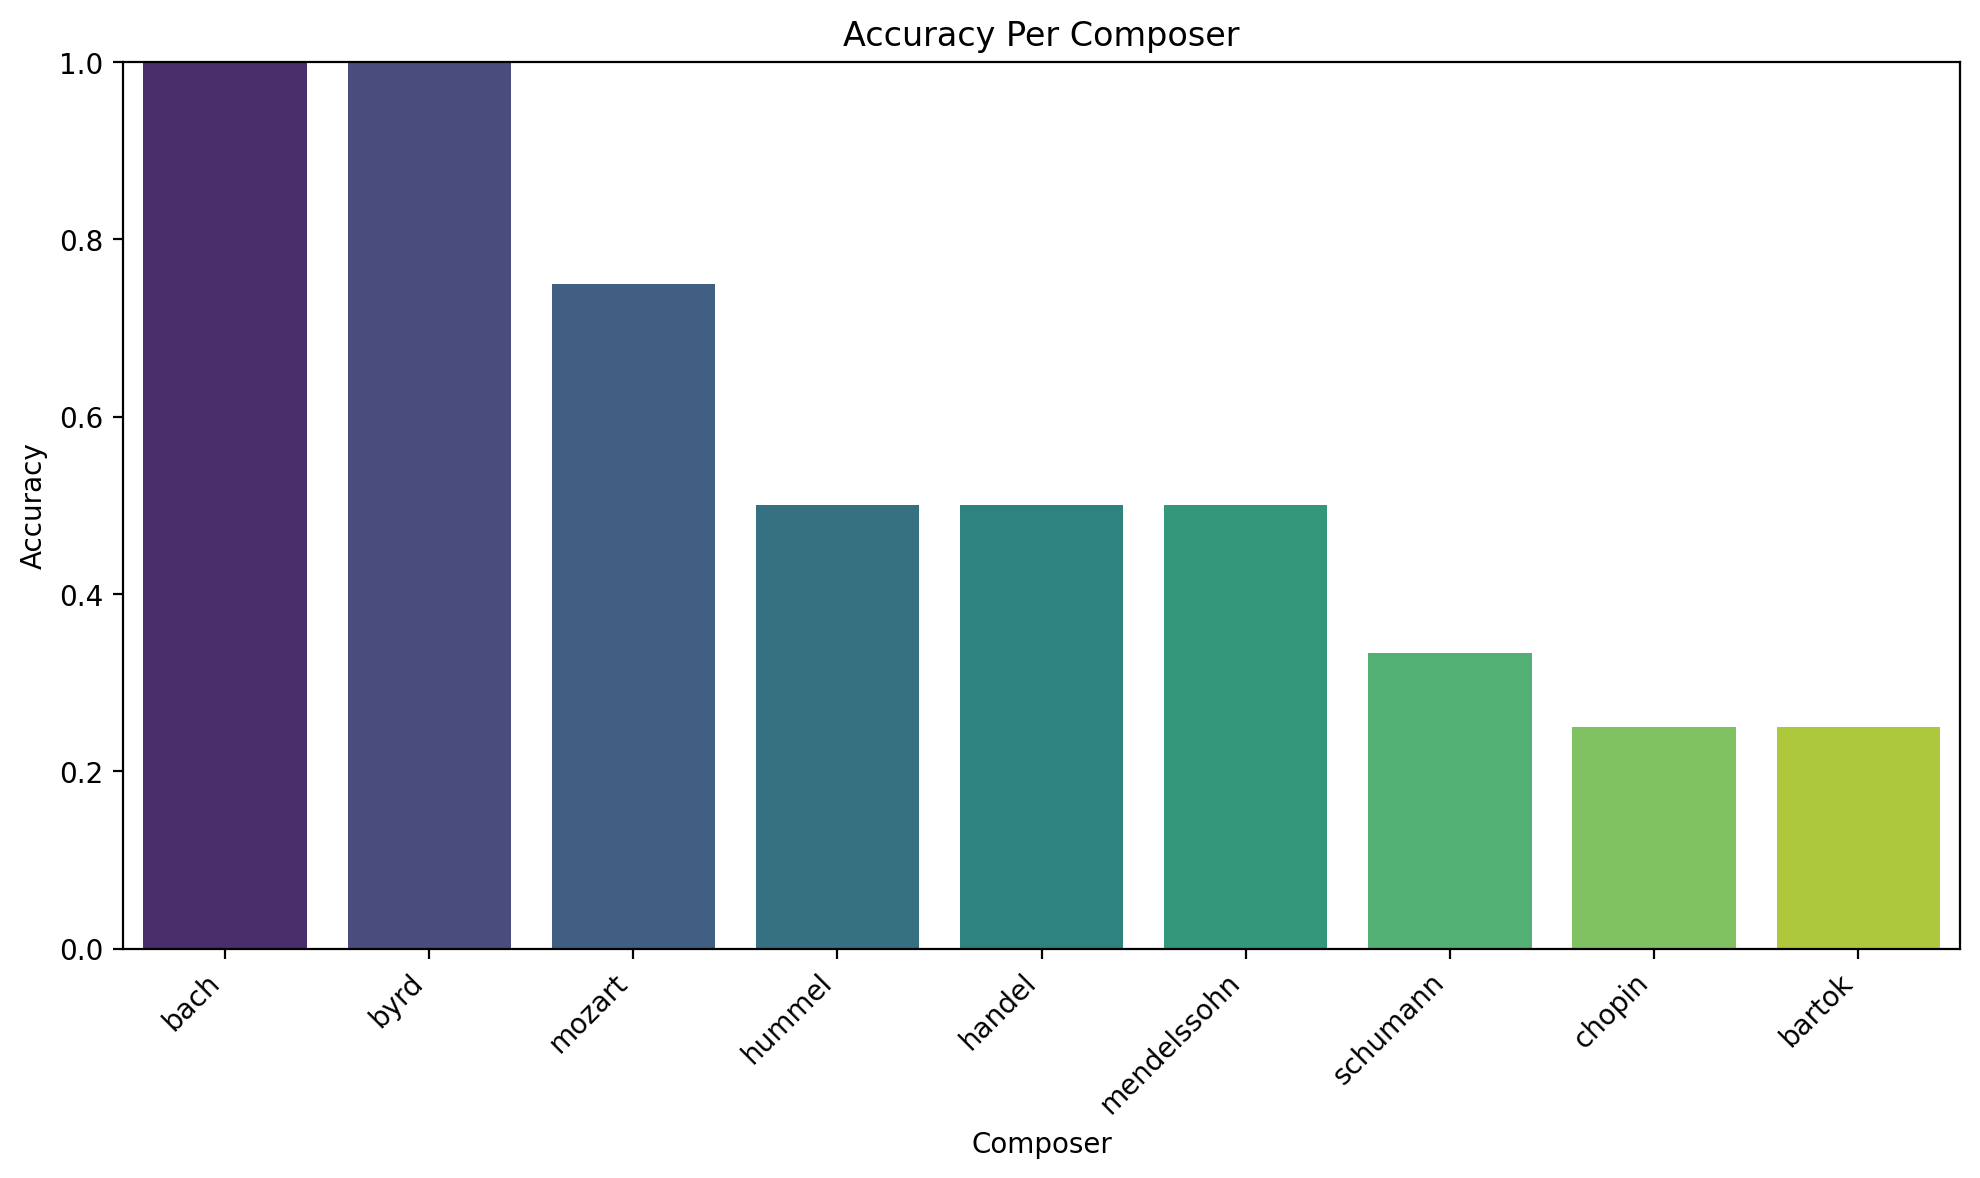

In [40]:
# Step 13: Accuracy per Composer (Bar Chart)
import pandas as pd # Import pandas here
print("\nAccuracy per Composer:")
# Get the true labels and predicted labels in string format for easier grouping
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Create a DataFrame to store results
results_df = pd.DataFrame({'True': y_test_decoded, 'Predicted': y_pred_decoded})

# Calculate accuracy for each composer
composer_accuracies = {}
for composer_name in label_encoder.classes_:
    composer_subset = results_df[results_df['True'] == composer_name]
    if not composer_subset.empty:
        correct_predictions = composer_subset[composer_subset['True'] == composer_subset['Predicted']]
        accuracy = len(correct_predictions) / len(composer_subset)
        composer_accuracies[composer_name] = accuracy
    else:
        composer_accuracies[composer_name] = 0.0 # No samples for this composer in test set

# Convert to DataFrame for plotting
accuracy_df = pd.DataFrame.from_dict(composer_accuracies, orient='index', columns=['Accuracy'])
accuracy_df = accuracy_df.sort_values(by='Accuracy', ascending=False) # Sort for better visualization

plt.figure(figsize=(10, 6))
sns.barplot(x=accuracy_df.index, y=accuracy_df['Accuracy'], palette='viridis')
plt.xlabel('Composer')
plt.ylabel('Accuracy')
plt.title('Accuracy Per Composer')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1) # Accuracy is between 0 and 1
plt.tight_layout()
plt.show()

**Chart Summary:**

This bar chart displays the classification accuracy for each composer, measuring how well the model predicts pieces by that composer in the test/validation set.

| Composer        | Accuracy |
| --------------- | -------- |
| **Bach**        | \~1.00   |
| **Byrd**        | \~1.00   |
| **Mozart**      | \~0.75   |
| **Hummel**      | \~0.50   |
| **Handel**      | \~0.50   |
| **Mendelssohn** | \~0.50   |
| **Schumann**    | \~0.33   |
| **Chopin**      | \~0.25   |
| **Bartok**      | \~0.25   |

**Key Interpretations:**


**High Accuracy Composers:**

*   Bach and Byrd are very well recognized by the model (100% accuracy).
*   Likely due to unique note patterns or stylistic features learned during training.
*   Could also mean their compositions are more distinct compared to others.

**Moderate Accuracy Composers:**

*   Mozart (~75%) and Hummel, Handel, Mendelssohn (~50%):
*   Model somewhat understands their style but may confuse them with others.


**Low Accuracy Composers:**

*   Schumann, Chopin, Bartok:
*   Consistently under 35%.

**Possible reasons:**

*   Overlapping musical features with other composers.
*   Fewer distinctive patterns captured by the model.
*   Insufficient training data or augmentation not effective for them.
*   Model could be overfitting to stronger classes like Bach/Byrd.

In [41]:
# Step 14: True vs Predicted Labels for a Sample of Test Data
print("\nTrue vs Predicted Labels (Sample from Test Set):")
sample_size = 20 # Number of samples to display
for i in range(min(sample_size, len(y_test_decoded))):
    print(f"Sample {i+1}: True Label: {y_test_decoded[i]:<15} | Predicted Label: {y_pred_decoded[i]}")


True vs Predicted Labels (Sample from Test Set):
Sample 1: True Label: mozart          | Predicted Label: mozart
Sample 2: True Label: mozart          | Predicted Label: mozart
Sample 3: True Label: mozart          | Predicted Label: mendelssohn
Sample 4: True Label: mozart          | Predicted Label: mozart
Sample 5: True Label: bartok          | Predicted Label: bartok
Sample 6: True Label: bartok          | Predicted Label: bach
Sample 7: True Label: bartok          | Predicted Label: byrd
Sample 8: True Label: bartok          | Predicted Label: mendelssohn
Sample 9: True Label: schumann        | Predicted Label: mendelssohn
Sample 10: True Label: schumann        | Predicted Label: schumann
Sample 11: True Label: schumann        | Predicted Label: chopin
Sample 12: True Label: byrd            | Predicted Label: byrd
Sample 13: True Label: byrd            | Predicted Label: byrd
Sample 14: True Label: byrd            | Predicted Label: byrd
Sample 15: True Label: byrd            | P

In [37]:
# Step 15: Predict on a New MIDI File
def predict_composer(midi_file_path, model, tokenizer, label_encoder, max_len):
    """
    Predicts the composer of a given MIDI file.
    """
    print(f"Processing MIDI file: {midi_file_path}")
    note_seq = extract_note_sequence(midi_file_path)

    if not note_seq:
        return "Could not process the MIDI file."

    # Convert to sequence of integers
    sequence = tokenizer.texts_to_sequences([note_seq])
    # Pad the sequence to MAX_LEN, consistent with training
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post')

    # Predict probabilities
    predictions = model.predict(padded_sequence)
    predicted_class_idx = np.argmax(predictions, axis=1)[0]

    # Inverse transform to get the composer name
    predicted_composer = label_encoder.inverse_transform([predicted_class_idx])[0]

    return predicted_composer

# Example usage (replace with an actual path to a MIDI file)
new_midi_file = "/content/testba.mid"
if os.path.exists(new_midi_file):
    predicted_composer_name = predict_composer(new_midi_file, model, tokenizer, label_encoder, MAX_LEN)
    print(f"\nThe predicted composer for {os.path.basename(new_midi_file)} is: {predicted_composer_name}")
else:
    print(f"Example MIDI file not found at {new_midi_file}. Please provide a valid path to test prediction.")

Processing MIDI file: /content/testba.mid
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step

The predicted composer for testba.mid is: bach


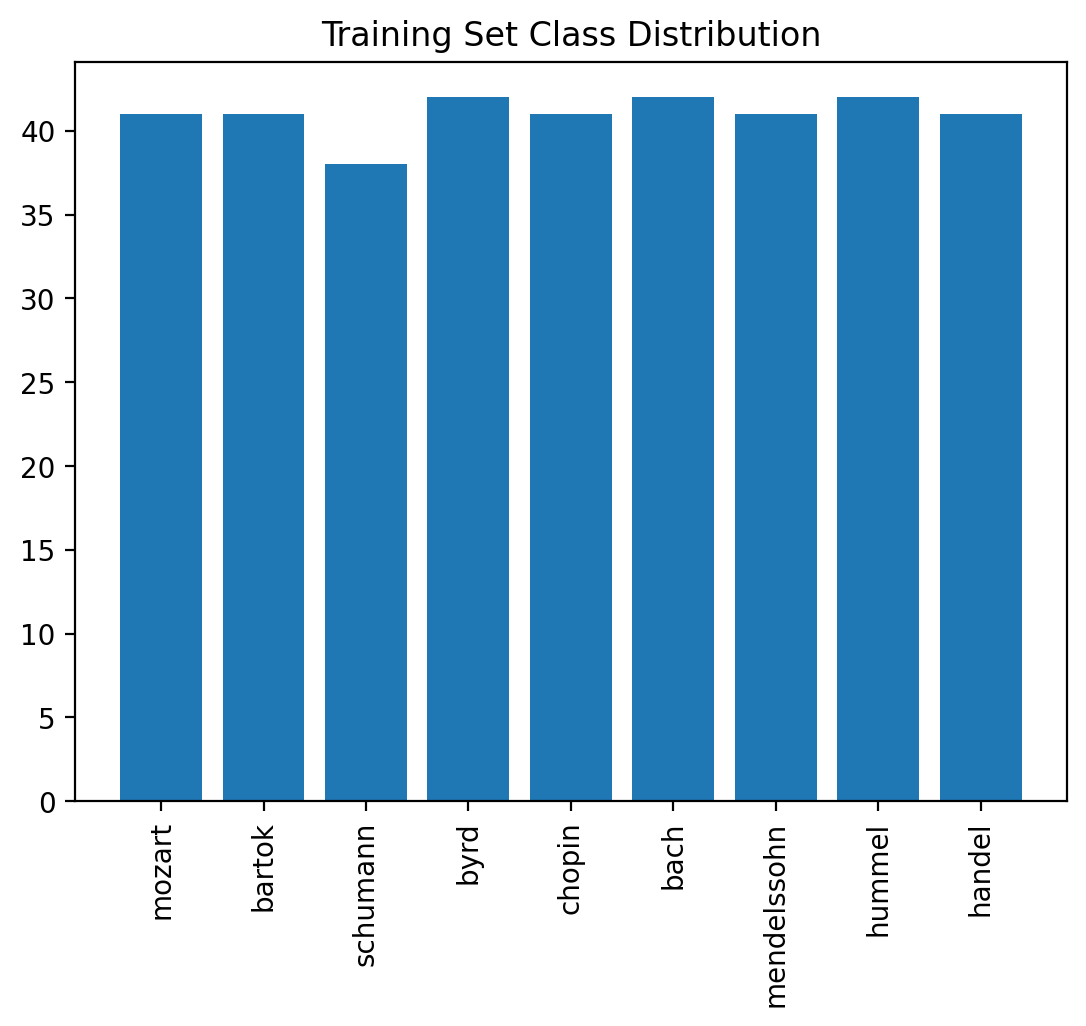

In [42]:
from collections import Counter
import matplotlib.pyplot as plt

counter = Counter(y_train_labels)
plt.bar(counter.keys(), counter.values())
plt.title("Training Set Class Distribution")
plt.xticks(rotation=90)
plt.show()

**Observations:**

*   The dataset is mostly balanced — each composer has around 41 to 43 samples.
*   Schumann has slightly fewer samples (~38), which is still close to the others.

**This balanced class distribution is beneficial for:**

*   Fair training (no class dominates).
*   Avoiding bias in predictions.
*   Reliable performance evaluation across all classes.